In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from src.visualization.visualize import *
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

from src.utils.constants import *

In [2]:
TEST_SIZE = 0.3
RANDOM_STATE = 42

In [3]:
merged_df = {}

for exchange in EXCHANGES:
  
    merged_df[(CANDLES, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{CANDLES}_{exchange}_merged.parquet'))
    merged_df[(ORDERBOOKS, exchange)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{ORDERBOOKS}_{exchange}_merged.parquet'))

In [4]:
for(exchange, data_type), df in merged_df.items():
    print(f'{exchange} {data_type}: {df.shape}')

candles BINANCE: (524101, 26)
orderbooks BINANCE: (478531, 82)
candles HUOBI: (405541, 26)
orderbooks HUOBI: (393119, 82)
candles OKX: (405553, 26)
orderbooks OKX: (393119, 82)


In [5]:
cols_to_drop = ['origin_time', 'label']
data = {}
X = {}
y = {}

for (data_type, exchange), df in merged_df.items():     
    data[(data_type, exchange)] = {}
    X[(data_type, exchange)] = merged_df[(data_type, exchange)].drop(cols_to_drop, axis=1)
    y[(data_type, exchange)] = merged_df[(data_type, exchange)]['label']
    data[(data_type, exchange)]['X_train'],  data[(data_type, exchange)]['X_test'],  data[(data_type, exchange)]['y_train'],  data[(data_type, exchange)]['y_test'] = train_test_split(
        X[(data_type, exchange)],
        y[(data_type, exchange)],
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE)

Best parameters for BINANCE candles: {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 10}
BINANCE candles Accuracy: 0.70
BINANCE candles Classification Report:


,precision,recall,f1-score,support
positive,0.373782,0.094381,0.150707,24380.000000
neutral,0.722824,0.970901,0.828694,108250.000000
negative,0.396616,0.091460,0.148642,24601.000000
accuracy,0.697388,0.697388,0.697388,0.697388
macro avg,0.497740,0.385580,0.376015,157231.000000
weighted avg,0.617662,0.697388,0.617163,157231.000000


BINANCE candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,2301,20112,1967
true:neutral,1694,105100,1456
true:negative,2161,20190,2250


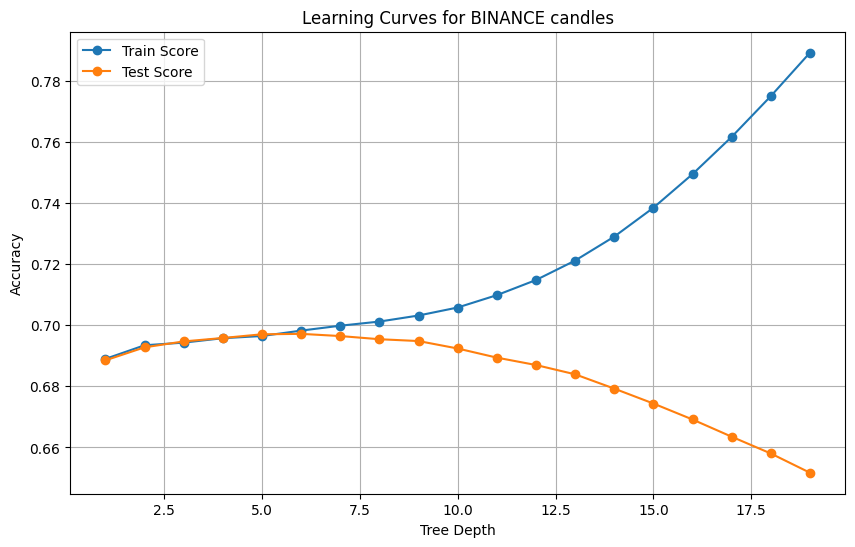

Best parameters for BINANCE orderbooks: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}


d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Repository\big_data_bitcoin_forecasting\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

BINANCE orderbooks Accuracy: 0.69
BINANCE orderbooks Classification Report:


,precision,recall,f1-score,support
positive,0.000000,0.000000,0.000000,21942.000000
neutral,0.693976,0.999870,0.819302,99620.000000
negative,0.310345,0.000409,0.000817,21998.000000
accuracy,0.693898,0.693898,0.693898,0.693898
macro avg,0.334773,0.333426,0.273373,143560.000000
weighted avg,0.529122,0.693898,0.568660,143560.000000


BINANCE orderbooks Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,0,21935,7
true:neutral,0,99607,13
true:negative,0,21989,9


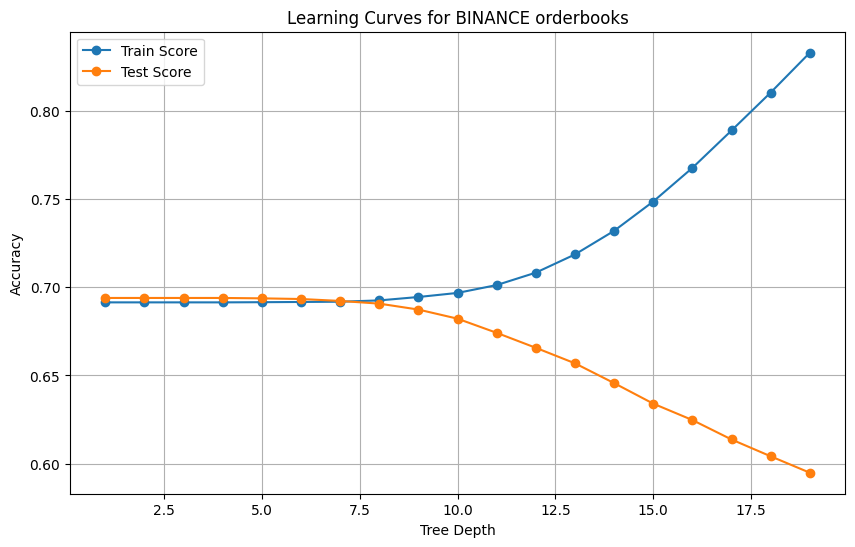

Best parameters for HUOBI candles: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 100}
HUOBI candles Accuracy: 0.71
HUOBI candles Classification Report:


,precision,recall,f1-score,support
positive,0.415086,0.050235,0.089624,18294.000000
neutral,0.715783,0.988061,0.830167,84931.000000
negative,0.434645,0.052121,0.093080,18438.000000
accuracy,0.705202,0.705202,0.705202,0.705202
macro avg,0.521838,0.363472,0.337623,121663.000000
weighted avg,0.627962,0.705202,0.607109,121663.000000


HUOBI candles Confusion Matrix:


,pred:positive,pred:neutral,pred:negative
true:positive,919,16602,773
true:neutral,537,83917,477
true:negative,758,16719,961


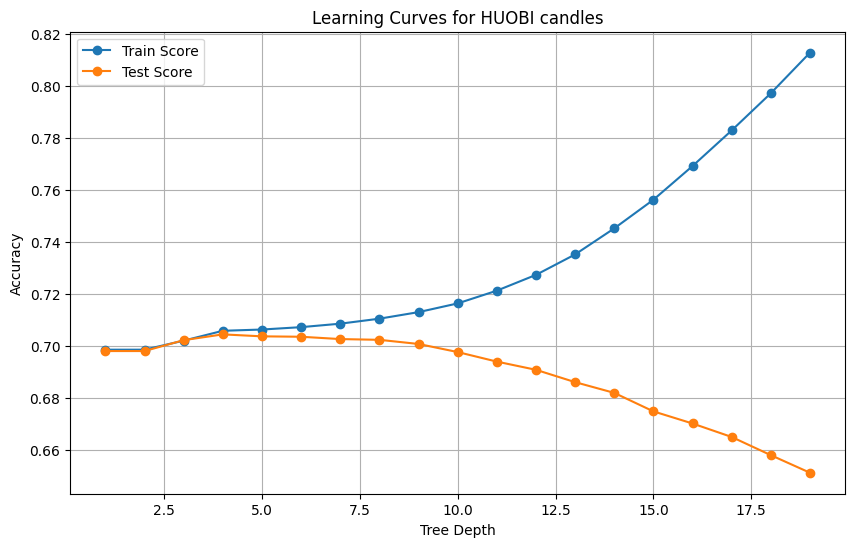

In [6]:
best_params = {}
best_score = {}
evaluation = {}

depth_range = range(1, 20)
min_samples_split_range = [10, 20, 50, 100]
min_samples_leaf_range = [10, 20, 30, 50]

for (data_type, exchange), df in data.items():
    clf = DecisionTreeClassifier(random_state=42)

    param_grid = {
        'max_depth': depth_range,
        'min_samples_split': min_samples_split_range,
        'min_samples_leaf': min_samples_leaf_range
    }

    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=CV_FOLDS, scoring='accuracy')

    # Fit the grid search to the data
    grid_search.fit(df['X_train'], df['y_train'])

    # Best depth
    best_params[(data_type, exchange)] = grid_search.best_params_
    best_score[(data_type, exchange)] = grid_search.best_score_
    print(f"Best parameters for {exchange} {data_type}: {best_params[(data_type, exchange)]}")

    # Train the classifier with the best max_depth
    clf = DecisionTreeClassifier(random_state=42, **best_params[(data_type, exchange)])
    clf.fit(df['X_train'], df['y_train'])

    # Predict on the test set
    df['y_pred'] = clf.predict(df['X_test'])

    evaluation[(data_type, exchange)] = {}

    # Calculate accuracy
    evaluation[(data_type, exchange)]['accuracy'] = accuracy_score(df['y_test'], df['y_pred'])

    # Convert classification report to DataFrame
    report = classification_report(df['y_test'], df['y_pred'], target_names=['positive', 'neutral', 'negative'], digits=2, output_dict=True)
    evaluation[(data_type, exchange)]['classification_report'] = pd.DataFrame(report).transpose()

    # Convert confusion matrix to DataFrame
    evaluation[(data_type, exchange)]['confusion_matrix'] = pd.DataFrame(
        confusion_matrix(df['y_test'], df['y_pred']),
        index=['true:positive', 'true:neutral', 'true:negative'],
        columns=['pred:positive', 'pred:neutral', 'pred:negative']
    )
    pd.DataFrame.to_pickle(evaluation, os.path.join(PROCESSED_DATA_PATH, f'{exchange}_{data_type}_evaluation.pkl'))

    # Display results
    print(f'{exchange} {data_type} Accuracy: {evaluation[(data_type, exchange)]["accuracy"]:.2f}')
    print(f'{exchange} {data_type} Classification Report:')
    display(evaluation[(data_type, exchange)]['classification_report'])
    print(f'{exchange} {data_type} Confusion Matrix:')
    display(evaluation[(data_type, exchange)]['confusion_matrix'])    

    # Calculate cross-validated train and test scores for plotting learning curves
    train_scores = []
    test_scores = []
    depths = depth_range

    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(df['X_train'], df['y_train'])
        train_scores.append(model.score(df['X_train'], df['y_train']))
        test_scores.append(np.mean(cross_val_score(model, df['X_test'], df['y_test'], cv=CV_FOLDS)))

    plot_tree_learning_curves(exchange, data_type, depths, train_scores, test_scores)


pd.DataFrame.to_pickle(best_params, os.path.join(PROCESSED_DATA_PATH, f'best_params.pkl'))
pd.DataFrame.to_pickle(best_score, os.path.join(PROCESSED_DATA_PATH, f'best_score.pkl'))

In [ ]:
# from sklearn.model_selection import cross_val_score

# for (data_type, exchange), df in data.items():
#     # Performing 10-fold cross-validation
#     scores = cross_val_score(clf[(data_type, exchange)], X[(data_type, exchange)], y[(data_type, exchange)], cv=10)
#     print("Average cross-validation score: {:.2f}".format(scores.mean()))


In [ ]:
# for (data_type, exchange), df in data.items():
#     if data_type == CANDLES and exchange == BINANCE:
#         # # Graphviz for Decision Trees
#         dot_data = export_graphviz(clf[(data_type, exchange)], out_file=None, 
#                                    feature_names=df['X_train'].columns, 
#                                    class_names=['positive', 'neutral', 'negative'], 
#                                    filled=True, rounded=True, special_characters=True)
#         graph = graphviz.Source(dot_data, format="png") 
#         graph.render(f'{exchange}_{data_type}_tree',  view=True, directory=FIGURE_PATH, cleanup=True, engine='dot')
#         graph.view(f'{exchange}_{data_type}_tree')

In [ ]:
# for (data_type, exchange), df in data.items():        
    # fig = plt.figure(figsize=(60,60))
    # _ = plot_tree(clf[(data_type, exchange)], feature_names=df['X_train'].columns, class_names=['positive', 'neutral', 'negative'], filled=True)
    # fig.savefig(os.path.join(FIGURE_PATH, f'{exchange}_{data_type}_tree.png'))    